In [280]:
# Import necessary libraries
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
import holidays

In [281]:
# Cell: Load and merge data

# Load the training data
train_data = pd.read_csv('data/train_energy.csv')

# Convert DateTime column to datetime type
train_data['DateTime'] = pd.to_datetime(train_data['DateTime'])

# Load the test data
test_data = pd.read_csv('data/test_energy.csv')

# Convert DateTime column to datetime type
test_data['DateTime'] = pd.to_datetime(test_data['DateTime'])

# Add an empty EnergyConsumption(kWh) column to test data
test_data['EnergyConsumption(kWh)'] = np.nan

# Merge train_data with test_data
data = pd.concat([train_data, test_data], ignore_index=True)

# Display the first few rows of the merged data
data.tail()

,DateTime,EnergyConsumption(kWh)
14587,2017-06-30 19:00:00,NaN
14588,2017-06-30 20:00:00,NaN
14589,2017-06-30 21:00:00,NaN
14590,2017-06-30 22:00:00,NaN
14591,2017-06-30 23:00:00,NaN


In [282]:
# Handling holidays (Example using Python's holidays library)
import holidays
country_holidays = holidays.US() # Replace with your country code (e.g., 'US', 'FR', etc.)

# Feature Engineering: Add more DateTime-related features
data['hour'] = data['DateTime'].dt.hour  # Hour of the day (0-23)
data['day_of_week'] = data['DateTime'].dt.dayofweek  # Day of the week (0=Monday, 6=Sunday)
data['month'] = data['DateTime'].dt.month  # Month of the year (1-12)
data['day_of_year'] = data['DateTime'].dt.dayofyear  # Day of the year (1-365 or 366)
# data['week_of_year'] = data['DateTime'].dt.isocalendar().week  # Week of the year
data['quarter'] = data['DateTime'].dt.quarter  # Quarter of the year (1-4)
data['is_weekend'] = data['DateTime'].dt.dayofweek.isin([5, 6]).astype(int)  # Is it a weekend? (1=True, 0=False)
data['is_holiday'] = data['DateTime'].isin(country_holidays).astype(int)
data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)  # Cyclical hour (sin transformation)
data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)  # Cyclical hour (cos transformation)
data['day_of_week_sin'] = np.sin(2 * np.pi * data['day_of_week'] / 7)  # Cyclical day of the week (sin transformation)
data['day_of_week_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 7)  # Cyclical day of the week (cos transformation)
data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)  # Cyclical month (sin transformation)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)  # Cyclical month (cos transformation)


def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

data['season'] = data['month'].apply(get_season)
data = pd.get_dummies(data, columns=['season'], drop_first=True)


# Display the first few rows of the dataset
data.head()



,DateTime,EnergyConsumption(kWh),hour,day_of_week,month,day_of_year,quarter,is_weekend,is_holiday,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos,season_Spring,season_Summer,season_Winter
0,2015-11-01 00:00:00,15.0,0,6,11,305,4,1,0,0.000000,1.000000,-0.781831,0.62349,-0.5,0.866025,False,False,False
1,2015-11-01 01:00:00,13.0,1,6,11,305,4,1,0,0.258819,0.965926,-0.781831,0.62349,-0.5,0.866025,False,False,False
2,2015-11-01 02:00:00,10.0,2,6,11,305,4,1,0,0.500000,0.866025,-0.781831,0.62349,-0.5,0.866025,False,False,False
3,2015-11-01 03:00:00,7.0,3,6,11,305,4,1,0,0.707107,0.707107,-0.781831,0.62349,-0.5,0.866025,False,False,False
4,2015-11-01 04:00:00,9.0,4,6,11,305,4,1,0,0.866025,0.500000,-0.781831,0.62349,-0.5,0.866025,False,False,False


In [283]:
# Cell: Filter data to a specific DateTime

# Example: Filter the data to a specific DateTime
specific_datetime = '2017-03-01 01:00:00'
filtered_data = data.loc[data['DateTime'] == specific_datetime]

# Display the filtered data
filtered_data

,DateTime,EnergyConsumption(kWh),hour,day_of_week,month,day_of_year,quarter,is_weekend,is_holiday,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos,season_Spring,season_Summer,season_Winter
11665,2017-03-01 01:00:00,NaN,1,2,3,60,1,0,0,0.258819,0.965926,0.974928,-0.222521,1.0,6.123234e-17,True,False,False


In [284]:
# Preprocess the data for Prophet
# Rename columns to 'ds' for DateTime and 'y' for the target variable
data.rename(columns={'DateTime': 'ds', 'EnergyConsumption(kWh)': 'y'}, inplace=True)

# Split the data into training and validation sets based on time
cutoff_date = '2017-01-01'  # Example cutoff date
train = data[data['ds'] < cutoff_date]
val = data[data['ds'] >= cutoff_date]

print('Training set:', train.shape)
print('Validation set:', val.shape)

print(train.head())
print(val.tail())

Training set: (10248, 18)
Validation set: (4344, 18)
                   ds     y  hour  day_of_week  month  day_of_year  quarter  \
0 2015-11-01 00:00:00  15.0     0            6     11          305        4   
1 2015-11-01 01:00:00  13.0     1            6     11          305        4   
2 2015-11-01 02:00:00  10.0     2            6     11          305        4   
3 2015-11-01 03:00:00   7.0     3            6     11          305        4   
4 2015-11-01 04:00:00   9.0     4            6     11          305        4   

   is_weekend  is_holiday  hour_sin  hour_cos  day_of_week_sin  \
0           1           0  0.000000  1.000000        -0.781831   
1           1           0  0.258819  0.965926        -0.781831   
2           1           0  0.500000  0.866025        -0.781831   
3           1           0  0.707107  0.707107        -0.781831   
4           1           0  0.866025  0.500000        -0.781831   

   day_of_week_cos  month_sin  month_cos  season_Spring  season_Summer  \
0

In [285]:
# Initialize the Prophet model
# model = Prophet()

# Initialize the Prophet model with tuned hyperparameters
# model = Prophet(
#     growth=best_params['growth'],
#     n_changepoints=best_params['n_changepoints'],
#     changepoint_range=best_params['changepoint_range'],
#     yearly_seasonality=best_params['yearly_seasonality'],
#     weekly_seasonality=best_params['weekly_seasonality'],
#     daily_seasonality=best_params['daily_seasonality'],
#     seasonality_mode=best_params['seasonality_mode'],
#     seasonality_prior_scale=best_params['seasonality_prior_scale'],
#     changepoint_prior_scale=best_params['changepoint_prior_scale'],
#     interval_width=best_params['interval_width'],
#     uncertainty_samples=best_params['uncertainty_samples']
# )


# Best Parameters: {'changepoint_prior_scale': 0.002656401744611492, 'seasonality_prior_scale': 3.593142936304888}
model = Prophet(
    changepoint_prior_scale=0.002656401744611492,
    seasonality_prior_scale=3.593142936304888,
)

# Add additional regressors
model.add_regressor('hour')
model.add_regressor('day_of_week')
model.add_regressor('month')
model.add_regressor('day_of_year')
# model.add_regressor('week_of_year')
model.add_regressor('quarter')
model.add_regressor('is_weekend')
model.add_regressor('is_holiday')
model.add_regressor('hour_sin')
model.add_regressor('hour_cos')
model.add_regressor('day_of_week_sin')
model.add_regressor('day_of_week_cos')
model.add_regressor('month_sin')
model.add_regressor('month_cos')
model.add_regressor('season_Spring')
model.add_regressor('season_Summer')
model.add_regressor('season_Winter')

# Fit the model on the training data
model.fit(train)

07:22:33 - cmdstanpy - INFO - Chain [1] start processing
07:22:34 - cmdstanpy - INFO - Chain [1] done processing


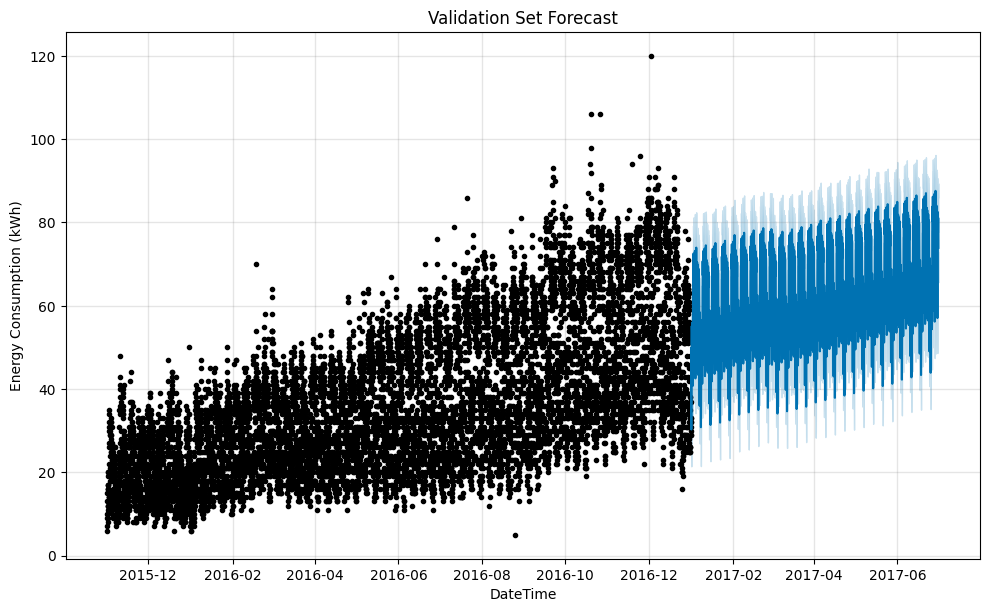

In [286]:
# Validate the model on the validation set
val_forecast = model.predict(val)

# Visualize the forecast on the validation set
fig = model.plot(val_forecast)
plt.title('Validation Set Forecast')
plt.xlabel('DateTime')
plt.ylabel('Energy Consumption (kWh)')
plt.show()


In [287]:
# Prepare the submission file
submission = val_forecast[['ds', 'yhat']].copy()
submission.rename(columns={'ds': 'DateTime', 'yhat': 'EnergyConsumption(kWh)'}, inplace=True)

#delete the first row of the submission
submission = submission[1:]

submission.head()

,DateTime,EnergyConsumption(kWh)
1,2017-01-01 01:00:00,44.468294
2,2017-01-01 02:00:00,39.228370
3,2017-01-01 03:00:00,34.898389
4,2017-01-01 04:00:00,31.899625
5,2017-01-01 05:00:00,30.308862


In [288]:
# Save to CSV
submission.to_csv('prophet_submission.csv', index=False)

# Display the first few rows of the submission file
submission.head()

,DateTime,EnergyConsumption(kWh)
1,2017-01-01 01:00:00,44.468294
2,2017-01-01 02:00:00,39.228370
3,2017-01-01 03:00:00,34.898389
4,2017-01-01 04:00:00,31.899625
5,2017-01-01 05:00:00,30.308862
